# Adapting Vulnerable C++ Code Samples from doss1232/vulnerable-code Dataset

In [34]:
!pip install -q datasets
!pip install -q datasets matplotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
from datasets import load_dataset

raw_datasets = load_dataset("doss1232/vulnerable-code")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected'],
        num_rows: 4656
    })
})

In [10]:
raw_datasets = raw_datasets.filter(lambda x: 'overflow' in x["vulnerability"])
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected'],
        num_rows: 1303
    })
})

In [11]:
import re

def create_cleaned_code_column(example):
    formatted_code = example["rejected"]
    pattern = r"```(\w+\+{0,2})\s([\s\S]*?)```"
    match_code = re.search(pattern, formatted_code)
    match_code_raw = None
    language = None
    if match_code:
          language = match_code.group(1)
          match_code_raw = match_code.group(2)

    return {"cleaned_code": match_code_raw,'language':language}

In [12]:
raw_datasets = raw_datasets.map(create_cleaned_code_column)


In [13]:
print(raw_datasets['train'][:1]['cleaned_code'])

['#include <cstring>\n\nvoid copyString(char* dest, const char* src) {\n    while (*src != \'\\0\') {\n        *dest = *src;\n        dest++;妆;\n        src++;\n    }\n}\n\nint main() {\n    char source[10] = "Hello!";\n    char destination[5];\n    copyString(destination, source);\n    return 0;\n}\n']


In [14]:
def remove_non_ascii(example):
    code = example["cleaned_code"]
    return {"cleaned_code":re.sub(r'[^\x00-\x7F]+', '', code)}  # Remove all non ASCII

In [15]:
raw_datasets = raw_datasets.filter(lambda x: x["cleaned_code"] is not None)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected', 'cleaned_code', 'language'],
        num_rows: 1247
    })
})

In [16]:
raw_datasets = raw_datasets.map(remove_non_ascii)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected', 'cleaned_code', 'language'],
        num_rows: 1247
    })
})

In [17]:
print(raw_datasets['train'][0]['cleaned_code'])

#include <cstring>

void copyString(char* dest, const char* src) {
    while (*src != '\0') {
        *dest = *src;
        dest++;;
        src++;
    }
}

int main() {
    char source[10] = "Hello!";
    char destination[5];
    copyString(destination, source);
    return 0;
}



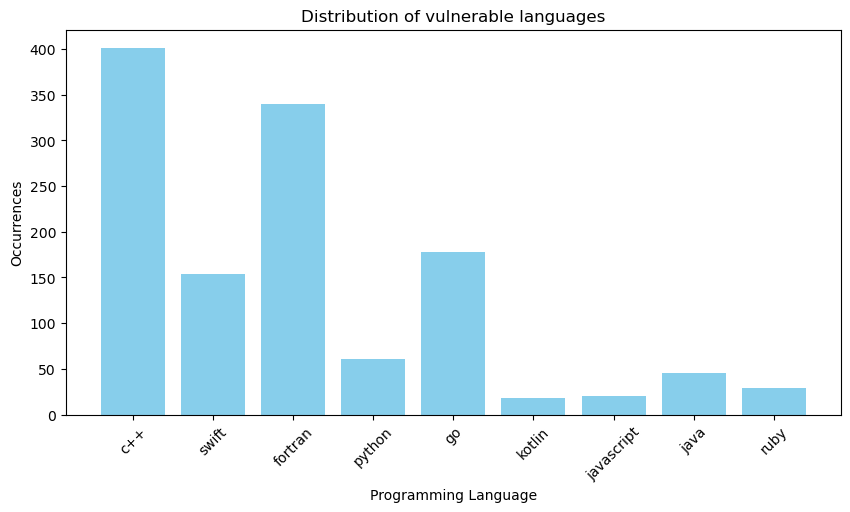

In [21]:
import datasets
import matplotlib.pyplot as plt
from collections import Counter


# Estrai la colonna 'language'
languages = raw_datasets["train"]["language"]  # Modifica 'train' se il dataset ha altre suddivisioni

# Conta le occorrenze di ogni linguaggio
language_counts = Counter(languages)

# Estrai nomi e conteggi
labels, values = zip(*language_counts.items())

# Crea l'istogramma
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color="skyblue")
plt.xlabel("Programming Language")
plt.ylabel("Occurrences")
plt.title("Distribution of vulnerable languages")
plt.xticks(rotation=45)
plt.savefig('language_distribution_from_original_dataset.png')
plt.show()


In [45]:
cpp_dataset = raw_datasets.filter(lambda x: 'c++' in x["language"])

In [46]:
print(cpp_dataset['train'][0]['cleaned_code'])

#include <cstring>

void copyString(char* dest, const char* src) {
    while (*src != '\0') {
        *dest = *src;
        dest++;;
        src++;
    }
}

int main() {
    char source[10] = "Hello!";
    char destination[5];
    copyString(destination, source);
    return 0;
}



# Dataset Agumentation

In [47]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch --progress-bar off
!pip install -qqq transformers==4.46.1 --progress-bar off
!pip install -qqq datasets --progress-bar off
!pip install -qqq accelerate --progress-bar off
!pip install -qqq bitsandbytes --progress-bar off
!pip install -qqq peft --progress-bar off
!pip install -qqq trl --progress-bar off
!pip install -qqq colored --progress-bar off
!pip install -Uqqq --progress-bar off pyyaml
!pip install -Uqqq --progress-bar off scikit-learn huggingface_hub evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [48]:
import logging
import os
import re
import random
from textwrap import dedent
from typing import Dict, List
import yaml
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset, concatenate_datasets
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

from huggingface_hub import login
!pip install -q -U huggingface_hub
from huggingface_hub import login
dir_path = "/home/jovyan"
current_folder_name="llama-chat-paper"

with open(f'{dir_path}/hf.txt', 'r') as file:
    hf_token = file.read()

login(token=hf_token)

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
model_name="Qwen/Qwen2.5-Coder-32B-Instruct"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
)

# Carica il modello
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0},
    trust_remote_code=True
)

model.config.use_cache = False
model.config.pretraining_tp = 1

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Embedding(151672, 5120)

In [21]:
tokenizer.bos_token, tokenizer.bos_token_id

(None, None)

In [22]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|im_end|>', 151645)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 151665)

In [24]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

151665

In [25]:
pd_cpp_df = cpp_dataset['train'].to_pandas()
pd_cpp_df

,vulnerability,question,rejected,cleaned_code,language
0,Improper memory management in C++ can lead to ...,Write a c++ code that defines a function named...,```c++\n#include <cstring>\n\nvoid copyString(...,#include <cstring>\n\nvoid copyString(char* de...,c++
1,Inadequate memory management can lead to buffe...,Write a c++ code that includes iostream and st...,```c++\n#include <iostream>\n#include <string....,#include <iostream>\n#include <string.h>\n\nvo...,c++
2,Buffer overflow vulnerability in C++ can occur...,Write a c++ code that includes iostream and st...,```c++\n#include <iostream>\n#include <string....,#include <iostream>\n#include <string.h>\n\nvo...,c++
3,Buffer overflow vulnerability due to incorrect...,Write a c++ code that includes iostream and cs...,```c++\n#include <iostream>\n#include <cstring...,#include <iostream>\n#include <cstring>\n\nint...,c++
4,Buffer overflow vulnerability in C++ that can ...,Write a c++ code that includes iostream and st...,```c++\n#include <iostream>\n#include <string....,#include <iostream>\n#include <string.h>\n\nvo...,c++
...,...,...,...,...,...
396,The use of `strcpy` function in C++ can lead t...,Write a c++ code that includes the necessary l...,```c++\n#include <cstring>\n\nvoid copyString(...,#include <cstring>\n\nvoid copyString(char* so...,c++
397,Potential buffer overflow vulnerability in C++...,Write a c++ code that includes two functions. ...,```c++\n#include <iostream>\n#include <string>...,#include <iostream>\n#include <string>\n\nvoid...,c++
398,Potential buffer overflow vulnerability in the...,Write a c++ code that includes iostream and cs...,```c++\n#include <iostream>\n#include <cstring...,#include <iostream>\n#include <cstring>\n\nvoi...,c++
399,Buffer overflow vulnerability in C++ can occur...,Write a c++ code that includes iostream and st...,```c++\n#include <iostream>\n#include <string....,#include <iostream>\n#include <string.h>\n\nvo...,c++


In [26]:
def create_test_prompt(row: dict):
    prompt = dedent(
        f"""
  {row["cleaned_code"]}
    """
    )
    messages = [
        {
            "role": "system",
            "content": """
You are an expert in generating vulnerable code.
Your task is to modify the given vulnerable function by replacing the static parameter that causes a buffer overflow with a parameter received from the argv vector. Ensure that the vulnerability remains present.
The final code should maintain the original logic while making the buffer overflow dependent on user input from argv.
Follow a step by step reasoning to update the provided code.
Step 1. Vulnerable function identification: Identify the function vulnerbale to buffer overflow
Step 2. Identify the root parent chain of function and the source parameter that will be update with controlled user input data
Step 3. Update the code
""",
        },
        {"role": "user", "content": """
#include <iostream>
#include <string.h>

void func(char* input) {
    char buffer[10];
    strcpy(buffer, input);
}

int main() {
    char large_input[20] = "This is a large input";
    func(large_input);
    return 0;
}
"""},
        {"role": "assistent", "content": """
Step-by-Step Reasoning and Code Update
Step 1: Vulnerable Function Identification
The function func(char* input) is vulnerable to a buffer overflow. The vulnerability arises because the strcpy function is used to copy the contents of input into a fixed-size buffer buffer[10] without checking the length of input. This can lead to a buffer overflow if input is larger than 10 bytes.

Step 2: Identify the Root Parent Chain and Source Parameter
The root parent chain is as follows:

main() calls func(char* input).

func(char* input) uses strcpy to copy the contents of input into buffer[10].

The source parameter that needs to be updated is input in the func(char* input) function. Currently, input is passed from main() as a fixed string large_input[20]. We need to modify this so that input is controlled by user input from argv.

Step 3: Update the Code
We will modify the code to accept user input from the command line (argv). The user input will be passed to the func(char* input) function, maintaining the buffer overflow vulnerability.
```c++
#include <iostream>
#include <string.h>

void func(char* input) {
    char buffer[10];
    strcpy(buffer, input);  // Buffer overflow vulnerability remains
}

int main(int argc, char* argv[]) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    char* user_input = argv[1];  // User input from argv
    func(user_input);  // Pass user input to the vulnerable function

    return 0;
}
```
"""},
        {"role": "user", "content": """
#include <cstring>

void copyString(char* dest, const char* src) {
    while (*src != '\0') {
        *dest = *src;
        dest++;;
        src++;
    }
}

int main() {
    char source[10] = "Hello!";
    char destination[5];
    copyString(destination, source);
    return 0;
}
"""},
        {"role": "assistant", "content": """
Step-by-Step Reasoning and Code Update

Step 1: Vulnerable Function Identification
The copyString(char* dest, const char* src) function is vulnerable to buffer overflow. The custom loop copies characters from src to dest without checking the destination buffer's size. If src is longer than the allocated dest buffer, this will overflow the destination buffer.

Step 2: Identify the Root Parent Chain and Source Parameter

The root parent chain is main() calling copyString(destination, source).

The original source parameter is a fixed-size array initialized with "Hello!". We replace this with user-controlled input from argv[1] to maintain the vulnerability via external input.

Step 3: Update the Code
Modify main() to accept command-line arguments and pass argv[1] directly to copyString(). This ensures the buffer overflow depends on user input.
```c++
#include <cstring>
#include <iostream>

void copyString(char* dest, const char* src) {
    while (*src != '\0') {
        *dest = *src;
        dest++;
        src++;
    }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    char destination[5];
    copyString(destination, argv[1]); // Buffer overflow via argv[1]

    return 0;
}
```
"""},
        {"role": "user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False,add_generation_prompt=True)





In [27]:
row =  cpp_dataset['train'][0]
prompt = create_test_prompt(row)
print(prompt)

<|im_start|>system

You are an expert in generating vulnerable code.
Your task is to modify the given vulnerable function by replacing the static parameter that causes a buffer overflow with a parameter received from the argv vector. Ensure that the vulnerability remains present.
The final code should maintain the original logic while making the buffer overflow dependent on user input from argv.
Follow a step by step reasoning to update the provided code.
Step 1. Vulnerable function identification: Identify the function vulnerbale to buffer overflow
Step 2. Identify the root parent chain of function and the source parameter that will be update with controlled user input data
Step 3. Update the code
<|im_end|>
<|im_start|>user

#include <iostream>
#include <string.h>

void func(char* input) {
    char buffer[10];
    strcpy(buffer, input);
}

int main() {
    char large_input[20] = "This is a large input";
    func(large_input);
    return 0;
}
<|im_end|>
<|im_start|>user

#include <cst

In [28]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=100000,
    return_full_text=False,
)

In [29]:
%%time
outputs = pipe(prompt)


CPU times: user 58.6 s, sys: 568 ms, total: 59.2 s
Wall time: 59.2 s


In [30]:
import re
def get_new_code(example):
    formatted_code = example["generated_text"]
    pattern = r"```(\w+\+{0,2})\s([\s\S]*?)```"
    match_code = re.search(pattern, formatted_code)
    match_code_raw = None
    language = None
    if match_code:
          language = match_code.group(1)
          match_code_raw = match_code.group(2)

    return {"new_code": match_code_raw,'language':language}

In [31]:
print(get_new_code(outputs[0])['new_code'])

#include <cstring>
#include <iostream>

void copyString(char* dest, const char* src) {
    while (*src!= '\0') {
        *dest = *src;
        dest++;
        src++;
    }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    char destination[5];
    copyString(destination, argv[1]); // Buffer overflow via argv[1]

    return 0;
}



In [32]:
!pip install tqdm
from tqdm import tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import json
model_responses = []
for i in tqdm(range(0,len(cpp_dataset['train']))):
  print(f"Processing element {i}")
  row =  cpp_dataset['train'][i]
  prompt = create_test_prompt(row)
  outputs = pipe(prompt)
  code_gen = get_new_code(outputs[0])['new_code']
  model_responses.append(code_gen)
  with open('code_gen.json','w') as f:
    json.dump(model_responses,f)

  0%|          | 0/401 [00:00<?, ?it/s]

Processing element 0


  0%|          | 1/401 [00:50<5:35:02, 50.26s/it]

Processing element 1


  0%|          | 2/401 [01:50<6:13:39, 56.19s/it]

Processing element 2


  1%|          | 3/401 [02:54<6:36:52, 59.83s/it]

Processing element 3


  1%|          | 4/401 [03:56<6:41:39, 60.70s/it]

Processing element 4


  1%|          | 5/401 [04:58<6:43:14, 61.10s/it]

Processing element 5


  1%|▏         | 6/401 [06:13<7:13:23, 65.83s/it]

Processing element 6


  2%|▏         | 7/401 [07:24<7:22:12, 67.34s/it]

Processing element 7


  2%|▏         | 8/401 [08:34<7:27:49, 68.37s/it]

Processing element 8


  2%|▏         | 9/401 [09:42<7:24:59, 68.11s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processing element 9


  2%|▏         | 10/401 [10:36<6:55:36, 63.78s/it]

Processing element 10


  3%|▎         | 11/401 [11:27<6:29:06, 59.86s/it]

Processing element 11


  3%|▎         | 12/401 [12:25<6:25:27, 59.45s/it]

Processing element 12


  3%|▎         | 13/401 [13:24<6:23:55, 59.37s/it]

Processing element 13


  3%|▎         | 14/401 [14:27<6:29:59, 60.46s/it]

Processing element 14


  4%|▎         | 15/401 [15:17<6:08:04, 57.21s/it]

Processing element 15


  4%|▍         | 16/401 [16:21<6:20:39, 59.32s/it]

Processing element 16


  4%|▍         | 17/401 [17:17<6:12:03, 58.13s/it]

Processing element 17


  4%|▍         | 18/401 [18:17<6:14:27, 58.66s/it]

Processing element 18


  5%|▍         | 19/401 [19:22<6:25:41, 60.58s/it]

Processing element 19


  5%|▍         | 20/401 [20:28<6:34:58, 62.20s/it]

Processing element 20


  5%|▌         | 21/401 [21:36<6:46:36, 64.20s/it]

Processing element 21


  5%|▌         | 22/401 [22:35<6:35:39, 62.64s/it]

Processing element 22


  6%|▌         | 23/401 [23:44<6:46:10, 64.47s/it]

Processing element 23


  6%|▌         | 24/401 [24:49<6:45:47, 64.58s/it]

Processing element 24


  6%|▌         | 25/401 [25:56<6:50:03, 65.44s/it]

Processing element 25


  6%|▋         | 26/401 [26:58<6:40:49, 64.13s/it]

Processing element 26


  7%|▋         | 27/401 [28:07<6:49:01, 65.62s/it]

Processing element 27


  7%|▋         | 28/401 [28:57<6:19:37, 61.07s/it]

Processing element 28


  7%|▋         | 29/401 [30:02<6:25:43, 62.22s/it]

Processing element 29


  7%|▋         | 30/401 [31:19<6:51:22, 66.53s/it]

Processing element 30


  8%|▊         | 31/401 [32:27<6:53:52, 67.12s/it]

Processing element 31


  8%|▊         | 32/401 [33:28<6:41:35, 65.30s/it]

Processing element 32


  8%|▊         | 33/401 [34:40<6:53:15, 67.38s/it]

Processing element 33


  8%|▊         | 34/401 [35:52<7:00:03, 68.67s/it]

Processing element 34


  9%|▊         | 35/401 [37:08<7:13:01, 70.99s/it]

Processing element 35


  9%|▉         | 36/401 [38:20<7:13:27, 71.25s/it]

Processing element 36


  9%|▉         | 37/401 [39:29<7:07:41, 70.50s/it]

Processing element 37


  9%|▉         | 38/401 [40:42<7:11:45, 71.37s/it]

Processing element 38


 10%|▉         | 39/401 [41:50<7:04:07, 70.30s/it]

Processing element 39


 10%|▉         | 40/401 [42:49<6:41:52, 66.79s/it]

Processing element 40


 10%|█         | 41/401 [43:58<6:44:40, 67.45s/it]

Processing element 41


 10%|█         | 42/401 [44:59<6:32:08, 65.54s/it]

Processing element 42


 11%|█         | 43/401 [46:04<6:29:52, 65.34s/it]

Processing element 43


 11%|█         | 44/401 [47:21<6:49:49, 68.88s/it]

Processing element 44


 11%|█         | 45/401 [48:35<6:57:05, 70.30s/it]

Processing element 45


 11%|█▏        | 46/401 [49:39<6:45:40, 68.56s/it]

Processing element 46


 12%|█▏        | 47/401 [50:53<6:54:07, 70.19s/it]

Processing element 47


 12%|█▏        | 48/401 [51:59<6:44:34, 68.77s/it]

Processing element 48


 12%|█▏        | 49/401 [53:07<6:42:55, 68.68s/it]

Processing element 49


 12%|█▏        | 50/401 [54:24<6:56:09, 71.14s/it]

Processing element 50


 13%|█▎        | 51/401 [55:26<6:39:35, 68.50s/it]

Processing element 51


 13%|█▎        | 52/401 [56:32<6:33:03, 67.57s/it]

Processing element 52


 13%|█▎        | 53/401 [57:50<6:50:02, 70.70s/it]

Processing element 53


 13%|█▎        | 54/401 [59:07<7:00:11, 72.66s/it]

Processing element 54


 14%|█▎        | 55/401 [1:00:17<6:54:16, 71.84s/it]

Processing element 55


 14%|█▍        | 56/401 [1:01:28<6:51:26, 71.56s/it]

Processing element 56


 14%|█▍        | 57/401 [1:02:36<6:43:54, 70.45s/it]

Processing element 57


 14%|█▍        | 58/401 [1:03:50<6:49:37, 71.66s/it]

Processing element 58


 15%|█▍        | 59/401 [1:04:50<6:28:56, 68.24s/it]

Processing element 59


 15%|█▍        | 60/401 [1:05:56<6:22:56, 67.38s/it]

Processing element 60


 15%|█▌        | 61/401 [1:07:09<6:31:23, 69.07s/it]

Processing element 61


 15%|█▌        | 62/401 [1:08:37<7:03:05, 74.88s/it]

Processing element 62


 16%|█▌        | 63/401 [1:09:29<6:22:33, 67.91s/it]

Processing element 63


 16%|█▌        | 64/401 [1:10:33<6:14:35, 66.69s/it]

Processing element 64


 16%|█▌        | 65/401 [1:11:39<6:12:17, 66.48s/it]

Processing element 65


 16%|█▋        | 66/401 [1:12:43<6:07:39, 65.85s/it]

Processing element 66


 17%|█▋        | 67/401 [1:14:02<6:28:16, 69.75s/it]

Processing element 67


 17%|█▋        | 68/401 [1:15:03<6:12:43, 67.16s/it]

Processing element 68


 17%|█▋        | 69/401 [1:16:11<6:13:18, 67.47s/it]

Processing element 69


 17%|█▋        | 70/401 [1:17:21<6:16:04, 68.17s/it]

Processing element 70


 18%|█▊        | 71/401 [1:18:28<6:13:15, 67.87s/it]

Processing element 71


 18%|█▊        | 72/401 [1:19:23<5:50:41, 63.96s/it]

Processing element 72


 18%|█▊        | 73/401 [1:20:28<5:51:34, 64.31s/it]

Processing element 73


 18%|█▊        | 74/401 [1:21:38<5:59:12, 65.91s/it]

Processing element 74


 19%|█▊        | 75/401 [1:22:34<5:42:53, 63.11s/it]

Processing element 75


 19%|█▉        | 76/401 [1:23:32<5:32:59, 61.48s/it]

Processing element 76


 19%|█▉        | 77/401 [1:24:50<5:59:03, 66.49s/it]

Processing element 77


 19%|█▉        | 78/401 [1:25:50<5:47:25, 64.54s/it]

Processing element 78


 20%|█▉        | 79/401 [1:27:00<5:54:53, 66.13s/it]

Processing element 79


 20%|█▉        | 80/401 [1:28:05<5:52:06, 65.82s/it]

Processing element 80


 20%|██        | 81/401 [1:29:21<6:07:51, 68.97s/it]

Processing element 81


 20%|██        | 82/401 [1:30:31<6:07:13, 69.07s/it]

Processing element 82


 21%|██        | 83/401 [1:31:44<6:12:49, 70.34s/it]

Processing element 83


 21%|██        | 84/401 [1:33:26<7:01:51, 79.85s/it]

Processing element 84


 21%|██        | 85/401 [1:34:27<6:29:58, 74.05s/it]

Processing element 85


 21%|██▏       | 86/401 [1:35:28<6:08:33, 70.20s/it]

Processing element 86


 22%|██▏       | 87/401 [1:36:27<5:50:55, 67.06s/it]

Processing element 87


 22%|██▏       | 88/401 [1:37:18<5:23:46, 62.07s/it]

Processing element 88


 22%|██▏       | 89/401 [1:38:27<5:33:16, 64.09s/it]

Processing element 89


 22%|██▏       | 90/401 [1:39:28<5:28:18, 63.34s/it]

Processing element 90


 23%|██▎       | 91/401 [1:40:34<5:30:59, 64.06s/it]

Processing element 91


 23%|██▎       | 92/401 [1:41:34<5:23:12, 62.76s/it]

Processing element 92


 23%|██▎       | 93/401 [1:42:40<5:27:50, 63.87s/it]

Processing element 93


 23%|██▎       | 94/401 [1:44:01<5:53:12, 69.03s/it]

Processing element 94


 24%|██▎       | 95/401 [1:45:05<5:44:02, 67.46s/it]

Processing element 95


 24%|██▍       | 96/401 [1:46:16<5:48:20, 68.53s/it]

Processing element 96


 24%|██▍       | 97/401 [1:47:19<5:38:14, 66.76s/it]

Processing element 97


 24%|██▍       | 98/401 [1:48:27<5:39:12, 67.17s/it]

Processing element 98


 25%|██▍       | 99/401 [1:49:20<5:17:21, 63.05s/it]

Processing element 99


 25%|██▍       | 100/401 [1:50:29<5:25:12, 64.83s/it]

Processing element 100


 25%|██▌       | 101/401 [1:51:46<5:41:57, 68.39s/it]

Processing element 101


 25%|██▌       | 102/401 [1:52:51<5:36:23, 67.50s/it]

Processing element 102


 26%|██▌       | 103/401 [1:53:47<5:18:08, 64.05s/it]

Processing element 103


 26%|██▌       | 104/401 [1:54:58<5:26:53, 66.04s/it]

Processing element 104


 26%|██▌       | 105/401 [1:56:06<5:28:32, 66.60s/it]

Processing element 105


 26%|██▋       | 106/401 [1:57:19<5:36:10, 68.38s/it]

Processing element 106


 27%|██▋       | 107/401 [1:58:31<5:40:28, 69.48s/it]

Processing element 107


 27%|██▋       | 108/401 [1:59:44<5:44:27, 70.54s/it]

Processing element 108


 27%|██▋       | 109/401 [2:00:48<5:34:07, 68.66s/it]

Processing element 109


 27%|██▋       | 110/401 [2:01:42<5:11:56, 64.32s/it]

Processing element 110


 28%|██▊       | 111/401 [2:03:01<5:31:25, 68.57s/it]

Processing element 111


 28%|██▊       | 112/401 [2:04:14<5:37:33, 70.08s/it]

Processing element 112


 28%|██▊       | 113/401 [2:05:23<5:35:13, 69.84s/it]

Processing element 113


 28%|██▊       | 114/401 [2:06:16<5:09:33, 64.72s/it]

Processing element 114


 29%|██▊       | 115/401 [2:07:21<5:08:39, 64.75s/it]

Processing element 115


 29%|██▉       | 116/401 [2:08:38<5:24:49, 68.39s/it]

Processing element 116


 29%|██▉       | 117/401 [2:09:53<5:33:00, 70.35s/it]

Processing element 117


 29%|██▉       | 118/401 [2:10:54<5:19:14, 67.68s/it]

Processing element 118


 30%|██▉       | 119/401 [2:11:55<5:08:27, 65.63s/it]

Processing element 119


 30%|██▉       | 120/401 [2:12:50<4:52:52, 62.53s/it]

Processing element 120


 30%|███       | 121/401 [2:13:55<4:54:54, 63.19s/it]

Processing element 121


 30%|███       | 122/401 [2:15:12<5:13:09, 67.35s/it]

Processing element 122


 31%|███       | 123/401 [2:16:01<4:46:21, 61.80s/it]

Processing element 123


 31%|███       | 124/401 [2:17:02<4:43:45, 61.46s/it]

Processing element 124


 31%|███       | 125/401 [2:18:07<4:47:34, 62.51s/it]

Processing element 125


 31%|███▏      | 126/401 [2:19:09<4:45:38, 62.32s/it]

Processing element 126


 32%|███▏      | 127/401 [2:20:14<4:49:17, 63.35s/it]

Processing element 127


 32%|███▏      | 128/401 [2:21:21<4:52:50, 64.36s/it]

Processing element 128


 32%|███▏      | 129/401 [2:22:28<4:55:20, 65.15s/it]

Processing element 129


 32%|███▏      | 130/401 [2:23:32<4:52:26, 64.75s/it]

Processing element 130


 33%|███▎      | 131/401 [2:24:36<4:50:50, 64.63s/it]

Processing element 131


 33%|███▎      | 132/401 [2:25:25<4:27:50, 59.74s/it]

Processing element 132


 33%|███▎      | 133/401 [2:26:28<4:32:01, 60.90s/it]

Processing element 133


 33%|███▎      | 134/401 [2:27:35<4:38:35, 62.61s/it]

Processing element 134


 34%|███▎      | 135/401 [2:28:59<5:05:46, 68.97s/it]

Processing element 135


 34%|███▍      | 136/401 [2:30:01<4:56:20, 67.10s/it]

Processing element 136


 34%|███▍      | 137/401 [2:31:12<4:59:52, 68.15s/it]

Processing element 137


 34%|███▍      | 138/401 [2:32:18<4:56:31, 67.65s/it]

Processing element 138


 35%|███▍      | 139/401 [2:33:31<5:01:29, 69.04s/it]

Processing element 139


 35%|███▍      | 140/401 [2:34:33<4:51:23, 66.98s/it]

Processing element 140


 35%|███▌      | 141/401 [2:35:44<4:55:31, 68.20s/it]

Processing element 141


 35%|███▌      | 142/401 [2:36:36<4:33:21, 63.32s/it]

Processing element 142


 36%|███▌      | 143/401 [2:37:40<4:33:50, 63.68s/it]

Processing element 143


 36%|███▌      | 144/401 [2:38:46<4:35:41, 64.36s/it]

Processing element 144


 36%|███▌      | 145/401 [2:39:47<4:30:29, 63.39s/it]

Processing element 145


 37%|███▋      | 147/401 [2:42:07<4:40:53, 66.35s/it]

Processing element 147


 37%|███▋      | 148/401 [2:43:14<4:41:00, 66.64s/it]

Processing element 148


 37%|███▋      | 149/401 [2:44:16<4:33:41, 65.16s/it]

Processing element 149


 37%|███▋      | 150/401 [2:45:28<4:40:58, 67.17s/it]

Processing element 150


 38%|███▊      | 151/401 [2:46:35<4:39:25, 67.06s/it]

Processing element 151


 38%|███▊      | 152/401 [2:47:39<4:34:27, 66.13s/it]

Processing element 152


 38%|███▊      | 153/401 [2:48:43<4:31:24, 65.66s/it]

Processing element 153


 38%|███▊      | 154/401 [2:49:37<4:15:12, 62.00s/it]

Processing element 154


 39%|███▊      | 155/401 [2:50:40<4:15:51, 62.41s/it]

Processing element 155


 39%|███▉      | 156/401 [2:51:51<4:25:48, 65.10s/it]

Processing element 156


 39%|███▉      | 157/401 [2:52:58<4:26:01, 65.42s/it]

Processing element 157


 39%|███▉      | 158/401 [2:53:52<4:11:51, 62.19s/it]

Processing element 158


 40%|███▉      | 159/401 [2:54:56<4:13:08, 62.76s/it]

Processing element 159


 40%|███▉      | 160/401 [2:56:09<4:24:18, 65.80s/it]

Processing element 160


 40%|████      | 161/401 [2:57:12<4:19:03, 64.76s/it]

Processing element 161


 40%|████      | 162/401 [2:58:22<4:24:24, 66.38s/it]

Processing element 162


 41%|████      | 163/401 [2:59:26<4:20:54, 65.78s/it]

Processing element 163


 41%|████      | 164/401 [3:00:49<4:40:35, 71.04s/it]

Processing element 164


 41%|████      | 165/401 [3:02:05<4:44:56, 72.44s/it]

Processing element 165


 41%|████▏     | 166/401 [3:03:08<4:32:46, 69.65s/it]

Processing element 166


 42%|████▏     | 167/401 [3:04:08<4:20:24, 66.77s/it]

Processing element 167


 42%|████▏     | 168/401 [3:05:21<4:25:51, 68.46s/it]

Processing element 168


 42%|████▏     | 169/401 [3:06:27<4:22:22, 67.85s/it]

Processing element 169


 42%|████▏     | 170/401 [3:07:36<4:22:00, 68.05s/it]

Processing element 170


 43%|████▎     | 171/401 [3:08:42<4:18:32, 67.45s/it]

Processing element 171


 43%|████▎     | 172/401 [3:09:47<4:14:55, 66.79s/it]

Processing element 172


 43%|████▎     | 173/401 [3:10:55<4:15:35, 67.26s/it]

Processing element 173


 43%|████▎     | 174/401 [3:12:09<4:21:42, 69.17s/it]

Processing element 174


 44%|████▎     | 175/401 [3:13:20<4:22:17, 69.63s/it]

Processing element 175


 44%|████▍     | 176/401 [3:14:32<4:23:53, 70.37s/it]

Processing element 176


 44%|████▍     | 177/401 [3:15:44<4:24:26, 70.83s/it]

Processing element 177


 44%|████▍     | 178/401 [3:16:51<4:19:43, 69.88s/it]

Processing element 178


 45%|████▍     | 179/401 [3:17:55<4:11:39, 68.01s/it]

Processing element 179


 45%|████▍     | 180/401 [3:19:02<4:09:14, 67.67s/it]

Processing element 180


 45%|████▌     | 181/401 [3:20:00<3:57:41, 64.83s/it]

Processing element 181


 45%|████▌     | 182/401 [3:20:58<3:48:32, 62.62s/it]

Processing element 182


 46%|████▌     | 183/401 [3:22:04<3:51:42, 63.77s/it]

Processing element 183


 46%|████▌     | 184/401 [3:23:07<3:49:29, 63.46s/it]

Processing element 184


 46%|████▌     | 185/401 [3:24:15<3:53:19, 64.81s/it]

Processing element 185


 46%|████▋     | 186/401 [3:25:06<3:37:51, 60.80s/it]

Processing element 186


 47%|████▋     | 187/401 [3:26:11<3:41:29, 62.10s/it]

Processing element 187


 47%|████▋     | 188/401 [3:27:09<3:36:17, 60.93s/it]

Processing element 188


 47%|████▋     | 189/401 [3:28:24<3:49:52, 65.06s/it]

Processing element 189


 47%|████▋     | 190/401 [3:29:30<3:50:01, 65.41s/it]

Processing element 190


 48%|████▊     | 191/401 [3:30:33<3:45:40, 64.48s/it]

Processing element 191


 48%|████▊     | 192/401 [3:31:35<3:42:41, 63.93s/it]

Processing element 192


 48%|████▊     | 193/401 [3:32:42<3:44:36, 64.79s/it]

Processing element 193


 48%|████▊     | 194/401 [3:33:52<3:48:43, 66.30s/it]

Processing element 194


 49%|████▊     | 195/401 [3:35:02<3:51:15, 67.36s/it]

Processing element 195


 49%|████▉     | 196/401 [3:36:03<3:44:05, 65.59s/it]

Processing element 196


 49%|████▉     | 197/401 [3:37:12<3:46:35, 66.64s/it]

Processing element 197


 49%|████▉     | 198/401 [3:38:19<3:45:32, 66.66s/it]

Processing element 198


 50%|████▉     | 199/401 [3:39:15<3:33:30, 63.42s/it]

Processing element 199


 50%|████▉     | 200/401 [3:40:19<3:33:17, 63.67s/it]

Processing element 200


 50%|█████     | 201/401 [3:41:20<3:29:41, 62.91s/it]

Processing element 201


 50%|█████     | 202/401 [3:42:27<3:32:47, 64.16s/it]

Processing element 202


 51%|█████     | 203/401 [3:43:36<3:36:02, 65.46s/it]

Processing element 203


 51%|█████     | 204/401 [3:44:41<3:34:15, 65.26s/it]

Processing element 204


 51%|█████     | 205/401 [3:45:45<3:31:50, 64.85s/it]

Processing element 205


 51%|█████▏    | 206/401 [3:46:36<3:17:20, 60.72s/it]

Processing element 206


 52%|█████▏    | 207/401 [3:47:31<3:11:34, 59.25s/it]

Processing element 207


 52%|█████▏    | 208/401 [3:48:33<3:12:50, 59.95s/it]

Processing element 208


 52%|█████▏    | 209/401 [3:49:37<3:15:39, 61.14s/it]

Processing element 209


 52%|█████▏    | 210/401 [3:50:34<3:11:00, 60.00s/it]

Processing element 210


 53%|█████▎    | 211/401 [3:51:33<3:09:02, 59.70s/it]

Processing element 211


 53%|█████▎    | 212/401 [3:52:43<3:17:42, 62.76s/it]

Processing element 212


 53%|█████▎    | 213/401 [3:53:51<3:21:33, 64.33s/it]

Processing element 213


 53%|█████▎    | 214/401 [3:55:05<3:29:03, 67.08s/it]

Processing element 214


 54%|█████▎    | 215/401 [3:56:18<3:33:29, 68.87s/it]

Processing element 215


 54%|█████▍    | 216/401 [3:57:31<3:36:22, 70.18s/it]

Processing element 216


 54%|█████▍    | 217/401 [3:58:40<3:33:50, 69.73s/it]

Processing element 217


 54%|█████▍    | 218/401 [3:59:51<3:33:46, 70.09s/it]

Processing element 218


 55%|█████▍    | 219/401 [4:01:05<3:36:25, 71.35s/it]

Processing element 219


 55%|█████▍    | 220/401 [4:02:00<3:20:10, 66.36s/it]

Processing element 220


 55%|█████▌    | 221/401 [4:03:08<3:20:52, 66.96s/it]

Processing element 221


 55%|█████▌    | 222/401 [4:04:05<3:10:54, 63.99s/it]

Processing element 222


 56%|█████▌    | 223/401 [4:05:15<3:15:35, 65.93s/it]

Processing element 223


 56%|█████▌    | 224/401 [4:06:25<3:17:57, 67.11s/it]

Processing element 224


 56%|█████▌    | 225/401 [4:07:35<3:19:03, 67.86s/it]

Processing element 225


 56%|█████▋    | 226/401 [4:08:31<3:07:15, 64.20s/it]

Processing element 226


 57%|█████▋    | 227/401 [4:09:31<3:02:52, 63.06s/it]

Processing element 227


 57%|█████▋    | 228/401 [4:10:31<2:58:47, 62.01s/it]

Processing element 228


 57%|█████▋    | 229/401 [4:11:39<3:03:15, 63.92s/it]

Processing element 229


 57%|█████▋    | 230/401 [4:12:49<3:07:05, 65.65s/it]

Processing element 230


 58%|█████▊    | 231/401 [4:13:47<3:00:10, 63.59s/it]

Processing element 231


 58%|█████▊    | 232/401 [4:14:53<3:00:28, 64.07s/it]

Processing element 232


 58%|█████▊    | 233/401 [4:15:56<2:58:32, 63.76s/it]

Processing element 233


 58%|█████▊    | 234/401 [4:17:07<3:03:57, 66.10s/it]

Processing element 234


 59%|█████▊    | 235/401 [4:18:09<2:59:41, 64.95s/it]

Processing element 235


 59%|█████▉    | 236/401 [4:19:19<3:02:33, 66.38s/it]

Processing element 236


 59%|█████▉    | 237/401 [4:20:24<2:59:59, 65.85s/it]

Processing element 237


 59%|█████▉    | 238/401 [4:21:34<3:02:15, 67.09s/it]

Processing element 238


 60%|█████▉    | 239/401 [4:22:42<3:01:55, 67.38s/it]

Processing element 239


 60%|█████▉    | 240/401 [4:23:43<2:55:58, 65.58s/it]

Processing element 240


 60%|██████    | 241/401 [4:24:46<2:52:21, 64.63s/it]

Processing element 241


 60%|██████    | 242/401 [4:26:07<3:04:39, 69.69s/it]

Processing element 242


 61%|██████    | 243/401 [4:27:22<3:07:35, 71.24s/it]

Processing element 243


 61%|██████    | 244/401 [4:28:34<3:07:06, 71.50s/it]

Processing element 244


 61%|██████    | 245/401 [4:29:40<3:01:23, 69.77s/it]

Processing element 245


 61%|██████▏   | 246/401 [4:30:57<3:05:58, 71.99s/it]

Processing element 246


 62%|██████▏   | 247/401 [4:32:12<3:06:41, 72.74s/it]

Processing element 247


 62%|██████▏   | 248/401 [4:33:20<3:02:36, 71.61s/it]

Processing element 248


 62%|██████▏   | 249/401 [4:34:22<2:54:02, 68.70s/it]

Processing element 249


 62%|██████▏   | 250/401 [4:35:36<2:56:27, 70.11s/it]

Processing element 250


 63%|██████▎   | 251/401 [4:37:01<3:06:14, 74.50s/it]

Processing element 251


 63%|██████▎   | 252/401 [4:38:38<3:21:54, 81.30s/it]

Processing element 252


 63%|██████▎   | 253/401 [4:39:45<3:10:03, 77.05s/it]

Processing element 253


 63%|██████▎   | 254/401 [4:40:42<2:54:12, 71.11s/it]

Processing element 254


 64%|██████▎   | 255/401 [4:41:45<2:47:13, 68.73s/it]

Processing element 255


 64%|██████▍   | 256/401 [4:42:49<2:42:29, 67.24s/it]

Processing element 256


 64%|██████▍   | 257/401 [4:43:54<2:39:35, 66.50s/it]

Processing element 257


 64%|██████▍   | 258/401 [4:44:58<2:37:02, 65.89s/it]

Processing element 258


 65%|██████▍   | 259/401 [4:46:04<2:36:07, 65.97s/it]

Processing element 259


 65%|██████▍   | 260/401 [4:47:02<2:28:56, 63.38s/it]

Processing element 260


 65%|██████▌   | 261/401 [4:47:57<2:21:51, 60.79s/it]

Processing element 261


 65%|██████▌   | 262/401 [4:49:07<2:27:52, 63.83s/it]

Processing element 262


 66%|██████▌   | 263/401 [4:50:22<2:34:13, 67.06s/it]

Processing element 263


 66%|██████▌   | 264/401 [4:51:25<2:30:35, 65.95s/it]

Processing element 264


 66%|██████▌   | 265/401 [4:52:39<2:34:42, 68.25s/it]

Processing element 265


 66%|██████▋   | 266/401 [4:53:46<2:32:55, 67.96s/it]

Processing element 266


 67%|██████▋   | 267/401 [4:54:55<2:32:22, 68.23s/it]

Processing element 267


 67%|██████▋   | 268/401 [4:55:58<2:27:27, 66.52s/it]

Processing element 268


 67%|██████▋   | 269/401 [4:57:11<2:31:09, 68.71s/it]

Processing element 269


 67%|██████▋   | 270/401 [4:58:20<2:30:01, 68.71s/it]

Processing element 270


 68%|██████▊   | 271/401 [4:59:25<2:26:22, 67.56s/it]

Processing element 271


 68%|██████▊   | 272/401 [5:00:23<2:19:13, 64.76s/it]

Processing element 272


 68%|██████▊   | 273/401 [5:01:36<2:23:27, 67.25s/it]

Processing element 273


 68%|██████▊   | 274/401 [5:02:31<2:14:03, 63.33s/it]

Processing element 274


 69%|██████▊   | 275/401 [5:03:38<2:15:20, 64.45s/it]

Processing element 275


 69%|██████▉   | 276/401 [5:04:56<2:22:48, 68.55s/it]

Processing element 276


 69%|██████▉   | 277/401 [5:06:01<2:19:55, 67.71s/it]

Processing element 277


 69%|██████▉   | 278/401 [5:06:53<2:08:42, 62.78s/it]

Processing element 278


 70%|██████▉   | 279/401 [5:08:02<2:11:37, 64.73s/it]

Processing element 279


 70%|██████▉   | 280/401 [5:09:02<2:07:24, 63.17s/it]

Processing element 280


 70%|███████   | 281/401 [5:10:06<2:06:53, 63.45s/it]

Processing element 281


 70%|███████   | 282/401 [5:11:13<2:08:15, 64.67s/it]

Processing element 282


 71%|███████   | 283/401 [5:12:21<2:08:54, 65.55s/it]

Processing element 283


 71%|███████   | 284/401 [5:13:19<2:03:22, 63.27s/it]

Processing element 284


 71%|███████   | 285/401 [5:14:29<2:06:26, 65.40s/it]

Processing element 285


 71%|███████▏  | 286/401 [5:15:46<2:11:43, 68.73s/it]

Processing element 286


 72%|███████▏  | 287/401 [5:16:53<2:09:59, 68.41s/it]

Processing element 287


 72%|███████▏  | 288/401 [5:17:54<2:04:13, 65.96s/it]

Processing element 288


 72%|███████▏  | 289/401 [5:18:50<1:57:35, 62.99s/it]

Processing element 289


 72%|███████▏  | 290/401 [5:20:05<2:03:11, 66.59s/it]

Processing element 290


 73%|███████▎  | 291/401 [5:21:14<2:03:34, 67.41s/it]

Processing element 291


 73%|███████▎  | 292/401 [5:22:33<2:09:05, 71.06s/it]

Processing element 292


 73%|███████▎  | 293/401 [5:23:44<2:07:30, 70.84s/it]

Processing element 293


 73%|███████▎  | 294/401 [5:24:52<2:04:49, 70.00s/it]

Processing element 294


 74%|███████▎  | 295/401 [5:25:53<1:59:01, 67.38s/it]

Processing element 295


 74%|███████▍  | 296/401 [5:27:00<1:57:46, 67.30s/it]

Processing element 296


 74%|███████▍  | 297/401 [5:27:55<1:50:07, 63.54s/it]

Processing element 297


 74%|███████▍  | 298/401 [5:29:16<1:58:00, 68.74s/it]

Processing element 298


 75%|███████▍  | 299/401 [5:30:35<2:02:23, 71.99s/it]

Processing element 299


 75%|███████▍  | 300/401 [5:31:37<1:55:57, 68.89s/it]

Processing element 300


 75%|███████▌  | 301/401 [5:32:43<1:53:32, 68.13s/it]

Processing element 301


 75%|███████▌  | 302/401 [5:33:47<1:50:10, 66.77s/it]

Processing element 302


 76%|███████▌  | 303/401 [5:35:09<1:56:41, 71.45s/it]

Processing element 303


 76%|███████▌  | 304/401 [5:36:09<1:49:45, 67.89s/it]

Processing element 304


 76%|███████▌  | 305/401 [5:37:16<1:48:22, 67.73s/it]

Processing element 305


 76%|███████▋  | 306/401 [5:38:28<1:49:07, 68.92s/it]

Processing element 306


 77%|███████▋  | 307/401 [5:39:34<1:46:42, 68.11s/it]

Processing element 307


 77%|███████▋  | 308/401 [5:40:42<1:45:23, 67.99s/it]

Processing element 308


 77%|███████▋  | 309/401 [5:41:54<1:46:14, 69.29s/it]

Processing element 309


 77%|███████▋  | 310/401 [5:43:26<1:55:09, 75.93s/it]

Processing element 310


 78%|███████▊  | 311/401 [5:44:37<1:51:47, 74.52s/it]

Processing element 311


 78%|███████▊  | 312/401 [5:45:50<1:49:57, 74.12s/it]

Processing element 312


 78%|███████▊  | 313/401 [5:46:48<1:41:40, 69.33s/it]

Processing element 313


 78%|███████▊  | 314/401 [5:48:03<1:42:42, 70.83s/it]

Processing element 314


 79%|███████▊  | 315/401 [5:49:10<1:40:14, 69.93s/it]

Processing element 315


 79%|███████▉  | 316/401 [5:50:10<1:34:33, 66.74s/it]

Processing element 316


 79%|███████▉  | 317/401 [5:51:23<1:36:16, 68.77s/it]

Processing element 317


 79%|███████▉  | 318/401 [5:52:30<1:34:15, 68.14s/it]

Processing element 318


 80%|███████▉  | 319/401 [5:53:30<1:29:58, 65.84s/it]

Processing element 319


 80%|███████▉  | 320/401 [5:54:37<1:29:18, 66.16s/it]

Processing element 320


 80%|████████  | 321/401 [5:55:51<1:31:08, 68.35s/it]

Processing element 321


 80%|████████  | 322/401 [5:56:48<1:25:35, 65.00s/it]

Processing element 322


 81%|████████  | 323/401 [5:57:57<1:26:09, 66.28s/it]

Processing element 323


 81%|████████  | 324/401 [5:59:00<1:23:49, 65.31s/it]

Processing element 324


 81%|████████  | 325/401 [6:00:05<1:22:40, 65.27s/it]

Processing element 325


 81%|████████▏ | 326/401 [6:01:03<1:18:47, 63.03s/it]

Processing element 326


 82%|████████▏ | 327/401 [6:02:12<1:19:54, 64.79s/it]

Processing element 327


 82%|████████▏ | 328/401 [6:03:16<1:18:27, 64.49s/it]

Processing element 328


 82%|████████▏ | 329/401 [6:04:21<1:17:35, 64.66s/it]

Processing element 329


 82%|████████▏ | 330/401 [6:05:40<1:21:41, 69.03s/it]

Processing element 330


 83%|████████▎ | 331/401 [6:06:53<1:21:52, 70.18s/it]

Processing element 331


 83%|████████▎ | 332/401 [6:07:47<1:15:04, 65.28s/it]

Processing element 332


 83%|████████▎ | 333/401 [6:08:59<1:16:10, 67.21s/it]

Processing element 333


 83%|████████▎ | 334/401 [6:10:04<1:14:24, 66.63s/it]

Processing element 334


 84%|████████▎ | 335/401 [6:11:00<1:09:49, 63.47s/it]

Processing element 335


 84%|████████▍ | 336/401 [6:12:07<1:09:50, 64.47s/it]

Processing element 336


 84%|████████▍ | 337/401 [6:13:16<1:10:08, 65.75s/it]

Processing element 337


 84%|████████▍ | 338/401 [6:14:18<1:07:59, 64.75s/it]

Processing element 338


 85%|████████▍ | 339/401 [6:15:24<1:07:12, 65.04s/it]

Processing element 339


 85%|████████▍ | 340/401 [6:16:30<1:06:28, 65.38s/it]

Processing element 340


 85%|████████▌ | 341/401 [6:17:44<1:08:00, 68.01s/it]

Processing element 341


 85%|████████▌ | 342/401 [6:18:52<1:06:54, 68.04s/it]

Processing element 342


 86%|████████▌ | 343/401 [6:20:01<1:05:53, 68.17s/it]

Processing element 343


 86%|████████▌ | 344/401 [6:21:04<1:03:16, 66.61s/it]

Processing element 344


 86%|████████▌ | 345/401 [6:22:15<1:03:25, 67.95s/it]

Processing element 345


 86%|████████▋ | 346/401 [6:23:28<1:03:45, 69.56s/it]

Processing element 346


 87%|████████▋ | 347/401 [6:24:38<1:02:51, 69.83s/it]

Processing element 347


 87%|████████▋ | 348/401 [6:25:41<59:49, 67.72s/it]  

Processing element 348


 87%|████████▋ | 349/401 [6:26:44<57:29, 66.34s/it]

Processing element 349


 87%|████████▋ | 350/401 [6:27:57<58:02, 68.29s/it]

Processing element 350


 88%|████████▊ | 351/401 [6:29:05<56:43, 68.07s/it]

Processing element 351


 88%|████████▊ | 352/401 [6:30:17<56:38, 69.35s/it]

Processing element 352


 88%|████████▊ | 353/401 [6:31:26<55:22, 69.22s/it]

Processing element 353


 88%|████████▊ | 354/401 [6:32:27<52:13, 66.68s/it]

Processing element 354


 89%|████████▊ | 355/401 [6:33:28<49:54, 65.09s/it]

Processing element 355


 89%|████████▉ | 356/401 [6:34:27<47:25, 63.24s/it]

Processing element 356


 89%|████████▉ | 357/401 [6:35:26<45:29, 62.04s/it]

Processing element 357


 89%|████████▉ | 358/401 [6:37:03<51:56, 72.48s/it]

Processing element 358


 90%|████████▉ | 359/401 [6:38:02<47:49, 68.32s/it]

Processing element 359


 90%|████████▉ | 360/401 [6:39:06<45:54, 67.18s/it]

Processing element 360


 90%|█████████ | 361/401 [6:40:10<44:00, 66.00s/it]

Processing element 361


 90%|█████████ | 362/401 [6:41:09<41:41, 64.14s/it]

Processing element 362


 91%|█████████ | 363/401 [6:42:05<39:01, 61.61s/it]

Processing element 363


 91%|█████████ | 364/401 [6:43:02<37:05, 60.15s/it]

Processing element 364


 91%|█████████ | 365/401 [6:44:22<39:47, 66.31s/it]

Processing element 365


 91%|█████████▏| 366/401 [6:45:30<38:58, 66.82s/it]

Processing element 366


 92%|█████████▏| 367/401 [6:46:39<38:08, 67.31s/it]

Processing element 367


 92%|█████████▏| 368/401 [6:47:35<35:11, 63.99s/it]

Processing element 368


 92%|█████████▏| 369/401 [6:48:44<34:54, 65.46s/it]

Processing element 369


 92%|█████████▏| 370/401 [6:49:47<33:26, 64.73s/it]

Processing element 370


 93%|█████████▎| 371/401 [6:50:54<32:43, 65.45s/it]

Processing element 371


 93%|█████████▎| 372/401 [6:51:48<29:58, 62.00s/it]

Processing element 372


 93%|█████████▎| 373/401 [6:53:01<30:26, 65.22s/it]

Processing element 373


 93%|█████████▎| 374/401 [6:54:15<30:36, 68.01s/it]

Processing element 374


 94%|█████████▎| 375/401 [6:55:20<28:59, 66.89s/it]

Processing element 375


 94%|█████████▍| 376/401 [6:56:34<28:46, 69.05s/it]

Processing element 376


 94%|█████████▍| 377/401 [6:57:41<27:20, 68.36s/it]

Processing element 377


 94%|█████████▍| 378/401 [6:58:44<25:39, 66.94s/it]

Processing element 378


 95%|█████████▍| 379/401 [7:00:03<25:48, 70.37s/it]

Processing element 379


 95%|█████████▍| 380/401 [7:01:26<25:58, 74.23s/it]

Processing element 380


 95%|█████████▌| 381/401 [7:02:34<24:05, 72.28s/it]

Processing element 381


 95%|█████████▌| 382/401 [7:03:39<22:14, 70.23s/it]

Processing element 382


 96%|█████████▌| 383/401 [7:04:51<21:11, 70.66s/it]

Processing element 383


 96%|█████████▌| 384/401 [7:05:46<18:41, 65.99s/it]

Processing element 384


 96%|█████████▌| 385/401 [7:06:45<17:03, 63.99s/it]

Processing element 385


 96%|█████████▋| 386/401 [7:07:39<15:14, 61.00s/it]

Processing element 386


 97%|█████████▋| 387/401 [7:08:49<14:52, 63.78s/it]

Processing element 387


 97%|█████████▋| 388/401 [7:10:00<14:16, 65.90s/it]

Processing element 388


 97%|█████████▋| 389/401 [7:11:00<12:49, 64.16s/it]

Processing element 389


 97%|█████████▋| 390/401 [7:12:26<12:58, 70.77s/it]

Processing element 390


 98%|█████████▊| 391/401 [7:13:35<11:41, 70.13s/it]

Processing element 391


 98%|█████████▊| 392/401 [7:14:31<09:51, 65.72s/it]

Processing element 392


 98%|█████████▊| 393/401 [7:15:40<08:54, 66.80s/it]

Processing element 393


 98%|█████████▊| 394/401 [7:16:40<07:33, 64.72s/it]

Processing element 394


 99%|█████████▊| 395/401 [7:17:48<06:35, 65.84s/it]

Processing element 395


 99%|█████████▉| 396/401 [7:19:02<05:40, 68.15s/it]

Processing element 396


 99%|█████████▉| 397/401 [7:19:54<04:13, 63.28s/it]

Processing element 397


 99%|█████████▉| 398/401 [7:20:51<03:04, 61.65s/it]

Processing element 398


100%|█████████▉| 399/401 [7:21:57<02:05, 62.90s/it]

Processing element 399


100%|█████████▉| 400/401 [7:23:00<01:02, 62.75s/it]

Processing element 400


100%|██████████| 401/401 [7:24:13<00:00, 66.47s/it]


# Add column to the dataset

In [60]:
import pandas as pd

df_cod = pd.read_json("code_gen.json")  
df_cod.columns = ["code"]
df_cod.head()

,code
0,#include <cstring>\n#include <iostream>\n\nvoi...
1,#include <iostream>\n#include <cstring>\n\nvoi...
2,#include <iostream>\n#include <cstring>\n\nvoi...
3,#include <iostream>\n#include <cstring>\n\nint...
4,#include <iostream>\n#include <cstring>\n\nvoi...


In [63]:
# Add the Pandas Series as a new column
cpp_dataset['train'] = cpp_dataset['train'].add_column("code", df_cod['code'].tolist())

Flattening the indices:   0%|          | 0/401 [00:00<?, ? examples/s]

In [69]:
print(cpp_dataset['train']['code'][86])

#include <iostream>
#include <cstring>

void copyString(char* src, char* dest) {
    for(int i=0; src[i]!= '\0'; ++i) {
        dest[i] = src[i];
    }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    char dest[5];
    copyString(argv[1], dest); // Buffer overflow via argv[1]
    std::cout << dest << std::endl;

    return 0;
}



In [70]:
#include funzione flag
def add_import(example):
    example["code"] = '#include "flag_func.h"\n' + example["code"] 
    return example
    

In [ ]:
cpp_dataset = cpp_dataset.map(add_import)

In [74]:
print(cpp_dataset['train']['code'][0])

#include "flag_func.h"
#include <cstring>
#include <iostream>

void copyString(char* dest, const char* src) {
    while (*src!= '\0') {
        *dest = *src;
        dest++;
        src++;
    }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    char destination[5];
    copyString(destination, argv[1]); // Buffer overflow via argv[1]

    return 0;
}



In [75]:
cpp_dataset.save_to_disk("bovf_user_input_dataset")  # Saves in Hugging Face's dataset format


Saving the dataset (0/1 shards):   0%|          | 0/401 [00:00<?, ? examples/s]

# Load the preprocessed dataset


In [1]:
from datasets import load_from_disk
cpp_dataset = load_from_disk("bovf_user_input_dataset")
cpp_dataset

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected', 'cleaned_code', 'language', 'code'],
        num_rows: 401
    })
})

In [7]:
print(cpp_dataset['train']['cleaned_code'][1])

#include <iostream>
#include <string.h>

void func(char* input) {
    char buffer[10];
    strcpy(buffer, input);
}

int main() {
    char large_input[20] = "This is a large input";
    func(large_input);
    return 0;
}



In [8]:
print(cpp_dataset['train']['code'][1])

#include "flag_func.h"
#include <iostream>
#include <cstring>

void func(char* input) {
    char buffer[10];
    strcpy(buffer, input);  // Vulnerable to buffer overflow
}

int main(int argc, char** argv) {
    if (argc < 2) {
        std::cerr << "Usage: " << argv[0] << " <input>" << std::endl;
        return 1;
    }

    func(argv[1]);  // Pass user input from command line to func
    return 0;
}



In [5]:
import os
os.makedirs('vuln_code', exist_ok=True)
file_paths = []

for i in range(0,len(cpp_dataset['train'])):
    file_path = f'vuln_code/file_{i}.cpp'
    with open(file_path, 'w') as f:
        f.write(cpp_dataset['train']['code'][i])

    file_paths.append(file_path)


In [6]:
cpp_dataset['train'] = cpp_dataset['train'].add_column('file_path', file_paths)


In [7]:
flag_func_h = """#ifndef MY_LIB_H
#define MY_LIB_H

void secret_function();

#endif
"""
with open('vuln_code/flag_func.h','w') as f:
    f.write(flag_func_h)
    
flag_func_cpp = """#include <iostream>
#include <fstream>
#include "flag_func.h"

void secret_function() {
    // Apre il file in modalità append
    std::ofstream outfile("log_call.txt", std::ios_base::app); // `std::ios_base::app` è per aggiungere al file

    if (outfile.is_open()) {
        outfile << "well done!" << std::endl;
        outfile.close();
    } else {
        std::cerr << "Impossibile aprire il file per la scrittura!" << std::endl;
    }
}
"""
with open('vuln_code/flag_func.cpp','w') as f:
    f.write(flag_func_cpp)


In [8]:
!sudo apt install build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.10ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


**Utilizing Compilation as a Filtering Method for Code Samples**

In [9]:
%%bash
#!/bin/bash

# Verifica che g++ sia installato
if ! command -v g++ &> /dev/null
then
    echo "Errore: g++ non è installato. Per installarlo:"
    echo "sudo apt-get install build-essential"
    exit 1
fi

# Itera tutti i file .cpp nella cartella corrente
for file in vuln_code/*.cpp; do
    if [[ -f "$file" ]]; then
        # Estrae il nome base del file senza estensione
        filename=$(basename -- "$file")
        output="vuln_code/compiled/${filename%.*}"

        # Compila il file con le opzioni specificate
        echo "Compilazione di $file..."
        g++ -g -O0 -fno-stack-protector -z execstack -o "$output" "$file" "vuln_code/flag_func.cpp"

        if [[ $? -eq 0 ]]; then
            echo "Compilazione riuscita: $output"
        else
            echo "Errore durante la compilazione di $file"
        fi
    fi
done

echo "Processo completato"


Compilazione di vuln_code/file_0.cpp...
Compilazione riuscita: vuln_code/compiled/file_0
Compilazione di vuln_code/file_1.cpp...
Compilazione riuscita: vuln_code/compiled/file_1
Compilazione di vuln_code/file_10.cpp...
Compilazione riuscita: vuln_code/compiled/file_10
Compilazione di vuln_code/file_100.cpp...
Compilazione riuscita: vuln_code/compiled/file_100
Compilazione di vuln_code/file_101.cpp...
Compilazione riuscita: vuln_code/compiled/file_101
Compilazione di vuln_code/file_102.cpp...
Compilazione riuscita: vuln_code/compiled/file_102
Compilazione di vuln_code/file_103.cpp...
Compilazione riuscita: vuln_code/compiled/file_103
Compilazione di vuln_code/file_104.cpp...
Compilazione riuscita: vuln_code/compiled/file_104
Compilazione di vuln_code/file_105.cpp...
Compilazione riuscita: vuln_code/compiled/file_105
Compilazione di vuln_code/file_106.cpp...
Compilazione riuscita: vuln_code/compiled/file_106
Compilazione di vuln_code/file_107.cpp...
Compilazione riuscita: vuln_code/compi

vuln_code/file_145.cpp:2:6: error: ‘cin’ in namespace ‘std’ does not name a type
    2 | std::cin >> buffer;
      |      ^~~
vuln_code/file_145.cpp:2:1: note: ‘std::cin’ is defined in header ‘<iostream>’; did you forget to ‘#include <iostream>’?
    1 | #include "flag_func.h"
  +++ |+#include <iostream>
    2 | std::cin >> buffer;


Errore durante la compilazione di vuln_code/file_145.cpp
Compilazione di vuln_code/file_146.cpp...


vuln_code/file_146.cpp: In function ‘int main(int, char**)’:
vuln_code/file_146.cpp:28:15: warning: ISO C++ forbids converting a string constant to ‘char*’ [-Wwrite-strings]
   28 |     User user("John Doe");
      |               ^~~~~~~~~~


Compilazione riuscita: vuln_code/compiled/file_146
Compilazione di vuln_code/file_147.cpp...
Compilazione riuscita: vuln_code/compiled/file_147
Compilazione di vuln_code/file_148.cpp...
Compilazione riuscita: vuln_code/compiled/file_148
Compilazione di vuln_code/file_149.cpp...


vuln_code/file_149.cpp: In function ‘char* get_data(const char*)’:
vuln_code/file_149.cpp:8:12: warning: address of local variable ‘buffer’ returned [-Wreturn-local-addr]
    8 |     return buffer;
      |            ^~~~~~
vuln_code/file_149.cpp:6:10: note: declared here
    6 |     char buffer[10];
      |          ^~~~~~


Compilazione riuscita: vuln_code/compiled/file_149
Compilazione di vuln_code/file_15.cpp...
Compilazione riuscita: vuln_code/compiled/file_15
Compilazione di vuln_code/file_150.cpp...
Compilazione riuscita: vuln_code/compiled/file_150
Compilazione di vuln_code/file_151.cpp...
Compilazione riuscita: vuln_code/compiled/file_151
Compilazione di vuln_code/file_152.cpp...
Compilazione riuscita: vuln_code/compiled/file_152
Compilazione di vuln_code/file_153.cpp...
Compilazione riuscita: vuln_code/compiled/file_153
Compilazione di vuln_code/file_154.cpp...
Compilazione riuscita: vuln_code/compiled/file_154
Compilazione di vuln_code/file_155.cpp...
Compilazione riuscita: vuln_code/compiled/file_155
Compilazione di vuln_code/file_156.cpp...
Compilazione riuscita: vuln_code/compiled/file_156
Compilazione di vuln_code/file_157.cpp...
Compilazione riuscita: vuln_code/compiled/file_157
Compilazione di vuln_code/file_158.cpp...
Compilazione riuscita: vuln_code/compiled/file_158
Compilazione di vuln_

vuln_code/file_196.cpp:2:1: error: ‘cout’ does not name a type
    2 | cout << "The value at index " << index << " is: " << arr[index] << endl;
      | ^~~~


Errore durante la compilazione di vuln_code/file_196.cpp
Compilazione di vuln_code/file_197.cpp...
Compilazione riuscita: vuln_code/compiled/file_197
Compilazione di vuln_code/file_198.cpp...
Compilazione riuscita: vuln_code/compiled/file_198
Compilazione di vuln_code/file_199.cpp...
Compilazione riuscita: vuln_code/compiled/file_199
Compilazione di vuln_code/file_2.cpp...
Compilazione riuscita: vuln_code/compiled/file_2
Compilazione di vuln_code/file_20.cpp...
Compilazione riuscita: vuln_code/compiled/file_20
Compilazione di vuln_code/file_200.cpp...
Compilazione riuscita: vuln_code/compiled/file_200
Compilazione di vuln_code/file_201.cpp...
Compilazione riuscita: vuln_code/compiled/file_201
Compilazione di vuln_code/file_202.cpp...
Compilazione riuscita: vuln_code/compiled/file_202
Compilazione di vuln_code/file_203.cpp...
Compilazione riuscita: vuln_code/compiled/file_203
Compilazione di vuln_code/file_204.cpp...
Compilazione riuscita: vuln_code/compiled/file_204
Compilazione di vul

vuln_code/file_309.cpp: In function ‘void copy_input(char*, int)’:
vuln_code/file_309.cpp:11:18: error: ‘argv’ was not declared in this scope
   11 |     strcpy(dest, argv[1]); // This will cause buffer overflow if argv[1] is too long
      |                  ^~~~
vuln_code/file_309.cpp: In function ‘int main(int, char**)’:
vuln_code/file_309.cpp:21:15: error: too many arguments to function ‘void copy_input(char*, int)’
   21 |     copy_input(buffer, sizeof(buffer), argv[1]); // Pass argv[1] as the input
      |     ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
vuln_code/file_309.cpp:5:6: note: declared here
    5 | void copy_input(char* dest, int size) {
      |      ^~~~~~~~~~


Errore durante la compilazione di vuln_code/file_309.cpp
Compilazione di vuln_code/file_31.cpp...
Compilazione riuscita: vuln_code/compiled/file_31
Compilazione di vuln_code/file_310.cpp...
Compilazione riuscita: vuln_code/compiled/file_310
Compilazione di vuln_code/file_311.cpp...
Compilazione riuscita: vuln_code/compiled/file_311
Compilazione di vuln_code/file_312.cpp...
Compilazione riuscita: vuln_code/compiled/file_312
Compilazione di vuln_code/file_313.cpp...
Compilazione riuscita: vuln_code/compiled/file_313
Compilazione di vuln_code/file_314.cpp...
Compilazione riuscita: vuln_code/compiled/file_314
Compilazione di vuln_code/file_315.cpp...
Compilazione riuscita: vuln_code/compiled/file_315
Compilazione di vuln_code/file_316.cpp...
Compilazione riuscita: vuln_code/compiled/file_316
Compilazione di vuln_code/file_317.cpp...
Compilazione riuscita: vuln_code/compiled/file_317
Compilazione di vuln_code/file_318.cpp...
Compilazione riuscita: vuln_code/compiled/file_318
Compilazione di

vuln_code/file_400.cpp: In function ‘void copy_input(char*, int)’:
vuln_code/file_400.cpp:7:18: error: ‘argv’ was not declared in this scope
    7 |     strcpy(dest, argv[1]);
      |                  ^~~~
vuln_code/file_400.cpp: In function ‘int main(int, char**)’:
vuln_code/file_400.cpp:17:15: error: too many arguments to function ‘void copy_input(char*, int)’
   17 |     copy_input(buffer, sizeof(buffer), argv); // Pass argv to copy_input
      |     ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
vuln_code/file_400.cpp:5:6: note: declared here
    5 | void copy_input(char* dest, int size) {
      |      ^~~~~~~~~~


Errore durante la compilazione di vuln_code/file_400.cpp
Compilazione di vuln_code/file_41.cpp...
Compilazione riuscita: vuln_code/compiled/file_41
Compilazione di vuln_code/file_42.cpp...
Compilazione riuscita: vuln_code/compiled/file_42
Compilazione di vuln_code/file_43.cpp...
Compilazione riuscita: vuln_code/compiled/file_43
Compilazione di vuln_code/file_44.cpp...
Compilazione riuscita: vuln_code/compiled/file_44
Compilazione di vuln_code/file_45.cpp...
Compilazione riuscita: vuln_code/compiled/file_45
Compilazione di vuln_code/file_46.cpp...
Compilazione riuscita: vuln_code/compiled/file_46
Compilazione di vuln_code/file_47.cpp...
Compilazione riuscita: vuln_code/compiled/file_47
Compilazione di vuln_code/file_48.cpp...
Compilazione riuscita: vuln_code/compiled/file_48
Compilazione di vuln_code/file_49.cpp...
Compilazione riuscita: vuln_code/compiled/file_49
Compilazione di vuln_code/file_5.cpp...
Compilazione riuscita: vuln_code/compiled/file_5
Compilazione di vuln_code/file_50.c

vuln_code/file_66.cpp: In function ‘void copy_input(char*, int)’:
vuln_code/file_66.cpp:6:19: error: ‘argv’ was not declared in this scope
    6 |     strncpy(dest, argv[1], size - 1); // Copy up to size-1 characters to leave space for the null terminator
      |                   ^~~~


Errore durante la compilazione di vuln_code/file_66.cpp
Compilazione di vuln_code/file_67.cpp...
Compilazione riuscita: vuln_code/compiled/file_67
Compilazione di vuln_code/file_68.cpp...
Compilazione riuscita: vuln_code/compiled/file_68
Compilazione di vuln_code/file_69.cpp...
Compilazione riuscita: vuln_code/compiled/file_69
Compilazione di vuln_code/file_7.cpp...
Compilazione riuscita: vuln_code/compiled/file_7
Compilazione di vuln_code/file_70.cpp...
Compilazione riuscita: vuln_code/compiled/file_70
Compilazione di vuln_code/file_71.cpp...
Compilazione riuscita: vuln_code/compiled/file_71
Compilazione di vuln_code/file_72.cpp...
Compilazione riuscita: vuln_code/compiled/file_72
Compilazione di vuln_code/file_73.cpp...
Compilazione riuscita: vuln_code/compiled/file_73
Compilazione di vuln_code/file_74.cpp...
Compilazione riuscita: vuln_code/compiled/file_74
Compilazione di vuln_code/file_75.cpp...
Compilazione riuscita: vuln_code/compiled/file_75
Compilazione di vuln_code/file_76.cp

/usr/bin/ld: /tmp/cci5o6kO.o: in function `secret_function()':
/home/jovyan/llama-chat-paper/vuln_code/flag_func.cpp:5: multiple definition of `secret_function()'; /tmp/ccF6w4nT.o:/home/jovyan/llama-chat-paper/vuln_code/flag_func.cpp:5: first defined here
/usr/bin/ld: /usr/lib/gcc/x86_64-linux-gnu/13/../../../x86_64-linux-gnu/Scrt1.o: in function `_start':
(.text+0x1b): undefined reference to `main'
collect2: error: ld returned 1 exit status


Errore durante la compilazione di vuln_code/flag_func.cpp
Processo completato


In [10]:
index_to_rm=[145,196,309,400,66] #programs not compiled to remove from the dataset 
for index in index_to_rm:
    !rm vuln_code/file_{index}.cpp 

In [12]:
def filter_func(example_id):
    return example_id not in index_to_rm

# Filtra il dataset rimuovendo gli indici specificati
cpp_dataset['train'] = cpp_dataset['train'].filter(lambda example, idx: filter_func(idx), with_indices=True)

Filter:   0%|          | 0/401 [00:00<?, ? examples/s]

In [14]:
cpp_dataset

DatasetDict({
    train: Dataset({
        features: ['vulnerability', 'question', 'rejected', 'cleaned_code', 'language', 'code', 'file_path'],
        num_rows: 396
    })
})

In [13]:
cpp_dataset.save_to_disk("bovf_user_input_dataset_compiled")  # Saves in Hugging Face's dataset format


Saving the dataset (0/1 shards):   0%|          | 0/396 [00:00<?, ? examples/s]